# Chlorophyll A Data Vis Workbook
### Amy Phung, August 2020

This notebook provides some minor revisions to the original figures presented in the extended abstract notebook. Notably:
+ At the time of writing, the original flow-through data did not have a fully up-to-date satellite dataset as a basis of comparison. The data was compared to the most recent data at the time as a stand-in. In this notebook, this figure is updated using currently available data.
+ The .nc files are now directly used (significant time & space improvement over converting data to a csv)

## Setup

In [10]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import glob
import datetime
from pandarallel import pandarallel
import scipy.interpolate
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## BGC Argo
The satellite data for the BGC Argo comparison was fully up-to-date in the original, so the original results are loaded here

In [2]:
compiled_results = pd.read_csv('data/compiled-data/3-31results2.csv', index_col=0)
compiled_results.head()

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat Chl-A,Sat Lat,Sat Long,Sat File
0,BGC,-32.465,185.24200,0.598395,1.501384e+09,1,0.220572,-32.479168,185.270828,data/satellite-data/autogenerated-csv\V2017209...
1,BGC,-32.267,185.30000,0.628195,1.502250e+09,2,0.276144,-32.270832,185.312500,data/satellite-data/autogenerated-csv\V2017217...
2,BGC,-32.298,185.25600,0.415293,1.503110e+09,3,0.211113,-32.312500,185.270828,data/satellite-data/autogenerated-csv\V2017225...
3,BGC,-32.560,185.32600,0.514820,1.503982e+09,4,0.181649,-32.562500,185.395828,data/satellite-data/autogenerated-csv\V2017233...
4,BGC,-32.979,185.25101,0.363909,1.504851e+09,5,0.204564,-32.979168,185.270828,data/satellite-data/autogenerated-csv\V2017249...


## Satellite Data Update
Fully up-to-date satellite data was not available when creating the original figures, so those figures are updated here

#### Satellite Data Class

In [3]:
class SatelliteDataset():
    def __init__(self, directory):
        self.lookup_df = self._createLookupTable(directory)
        
    def _parseTimestamps(self, files):
        ts_starts, ts_ends = [], []

        for f in files:
            # Parse filename to find date
            start_idx = f.find("V") + 1 
            year_st  = int(f[start_idx:start_idx + 4]) # Year is 4 chars long 
            day_st   = int(f[start_idx + 4:start_idx + 7]) # Day is 3 chars long
            year_end = int(f[start_idx + 7:start_idx + 11]) 
            day_end  = int(f[start_idx + 11:start_idx + 14]) 

            # Convert from date to timestamp
            time_st = datetime.datetime(year_st, 1, 1) \
                      + datetime.timedelta(day_st - 1)
            time_end = datetime.datetime(year_end, 1, 1) \
                      + datetime.timedelta(day_end)
        
            # Add to output array
            ts_starts.append(time_st.timestamp())
            ts_ends.append(time_end.timestamp())
            
        return ts_starts, ts_ends
    
    def _createLookupTable(self, directory):
        """ Creates lookup table for finding appropriate file by time """
        file_list = glob.glob('%s/*.nc' % directory)
        ts_starts, ts_ends = self._parseTimestamps(file_list)
        
        l_df = pd.DataFrame([file_list, ts_starts, ts_ends]).T
        l_df.columns=["Filename", "Time Start", "Time End"]
        l_df = l_df.sort_values(by=["Time Start"])
        l_df.reset_index(inplace=True, drop=True)
        return l_df
    
    def findBestFile(self, timestamp):
        """For a given timestamp, finds the best satellite data file"""

        valid_st = self.lookup_df[(timestamp >= self.lookup_df["Time Start"])]
        if len(valid_st) == 0: # Timestamp is earlier than available data
            print("Warning: Timestamp is earlier than available data. Using first available file")
            return str(self.lookup_df.iloc[0]["Filename"])
        
        valid_end = valid_st[timestamp < valid_st["Time End"]]
        if len(valid_end) == 0: # Timestamp is later than available data
            print("Warning: Timestamp is later than available data. Using last available file")
            return str(self.lookup_df.iloc[-1]["Filename"])
        return str(valid_end.iloc[-1]["Filename"])

In [4]:
# Initialize satellite dataset
sat_data = SatelliteDataset('data/satellite-data')

In [5]:
# Create list of new satellite files
new_sat_list = compiled_results[compiled_results["Src"] == "FT"]["Timestamp"].parallel_apply(sat_data.findBestFile)

#### Compute new chl-a, lats, long values for all flow-through points

In [63]:
def lookupChlorophyll(df_row, lons, lats, chls):
    """ Looks up nearest satellite point for each flow-through 
    point and returns the corresponding chlorophyll value """
    
    lon_idx = abs(lons-df_row["Long"]).argmin()
    lat_idx = abs(lats-df_row["Lat"]).argmin()
    
    # Check if data is invalid
    if chls.mask[lat_idx][lon_idx] == True:
        return np.nan

    chl_val = chls[lat_idx][lon_idx]
    return chl_val

temp_sat_list = []

for f in new_sat_list.unique():
    fh = Dataset(f, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    chls = fh.variables['chlor_a'][:]
    fh.close()

    # Extract flow-through data with current sat file name
    new_sat_df = compiled_results[compiled_results["Src"] == "FT"] \
                                 [new_sat_list == f] \
                                 .parallel_apply(lookupChlorophyll, axis=1, args=(lons,lats,chls,))
    temp_sat_list.append(new_sat_df)
    
new_sat_data = pd.concat(temp_sat_list)

In [68]:
# new_sat_data
new_sat_data[~np.isnan(new_sat_data)]

93       1.068479
94       1.068479
95       1.068479
96       1.068479
97       1.068479
98       1.068479
99       1.068479
100      1.068479
101      1.068479
102      1.068479
103      1.068479
104      1.068479
105      1.068479
106      1.068479
107      1.068479
108      1.068479
109      1.068479
110      1.068479
111      1.068479
112      1.068479
113      1.068479
114      1.068479
115      0.783461
116      0.783461
117      0.783461
118      0.783461
119      0.783461
120      0.548727
121      0.548727
122      0.548727
           ...   
25383    0.372834
25384    0.372834
25385    0.372834
25386    0.372834
25387    0.409988
25388    0.409988
25389    0.409988
25390    0.409988
25391    0.409988
25392    0.409988
25393    0.409988
25394    0.409988
25395    0.409988
25396    0.409988
25397    0.409988
25398    0.409988
25399    0.409988
25400    0.409988
25401    0.409988
25402    0.409988
25403    0.409988
25404    0.409988
25405    0.409988
25406    0.409988
25407    0

In [56]:
temp_sat_list[0][~np.isnan(temp_sat_list[0])]

93      1.068479
94      1.068479
95      1.068479
96      1.068479
97      1.068479
98      1.068479
99      1.068479
100     1.068479
101     1.068479
102     1.068479
103     1.068479
104     1.068479
105     1.068479
106     1.068479
107     1.068479
108     1.068479
109     1.068479
110     1.068479
111     1.068479
112     1.068479
113     1.068479
114     1.068479
115     0.783461
116     0.783461
117     0.783461
118     0.783461
119     0.783461
120     0.548727
121     0.548727
122     0.548727
          ...   
7889    0.108241
7890    0.108241
7891    0.108241
7892    0.108241
7893    0.108241
7894    0.108241
7895    0.108241
7896    0.108241
7897    0.108241
7898    0.108241
7899    0.108241
7900    0.108241
7901    0.108241
7902    0.108241
7903    0.108241
7904    0.108241
7905    0.108241
7906    0.108241
7907    0.108241
7908    0.108241
7909    0.108241
7910    0.108241
7911    0.108241
7912    0.108241
7913    0.108241
7914    0.108241
7915    0.108241
7916    0.1082

In [24]:
f = new_sat_list.iloc[0]
fh = Dataset(f, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
chls = fh.variables['chlor_a'][:]
fh.close()

x1 = lons.data
y1 = lats.data
z1 = chls

# print(y1[0:-1] - y1[1:])
interp_spline = scipy.interpolate.RectBivariateSpline(abs(y1), x1, z1)(np.arange(z1.shape[0]), np.arange(z1.shape[1]))
interp_spline

array([[ 4.54213176e-02,  4.15157940e-02,  4.86006040e-02, ...,
         1.04262315e-01,  1.04262315e-01,  1.04262315e-01],
       [ 4.54213176e-02,  4.15157940e-02,  4.86006040e-02, ...,
         1.04262315e-01,  1.04262315e-01,  1.04262315e-01],
       [ 4.54213176e-02,  4.15157940e-02,  4.86006040e-02, ...,
         1.04262315e-01,  1.04262315e-01,  1.04262315e-01],
       ...,
       [ 2.49670524e-01,  4.15715068e-01, -3.29988285e+04, ...,
        -3.27670000e+04, -3.27670000e+04, -3.27670000e+04],
       [ 2.49670524e-01,  4.15715068e-01, -3.29988285e+04, ...,
        -3.27670000e+04, -3.27670000e+04, -3.27670000e+04],
       [ 2.49670524e-01,  4.15715068e-01, -3.29988285e+04, ...,
        -3.27670000e+04, -3.27670000e+04, -3.27670000e+04]])

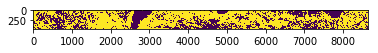

In [37]:
chls[0][0]
plt.imshow(chls.data)
# plt.xlim([0,400])

(0, 400)

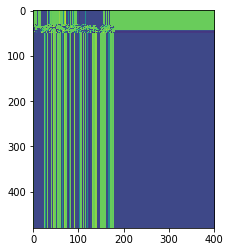

In [35]:
interp_spline[0][0]
plt.imshow(interp_spline)
plt.xlim([0,400])

In [19]:
for i, j in zip(y1, y1[1:]):
    if (i < j):
       print("No, List is sorted.")

In [20]:
y1

array([-30.020834, -30.0625  , -30.104166, -30.145834, -30.1875  ,
       -30.229166, -30.270834, -30.3125  , -30.354166, -30.395834,
       -30.4375  , -30.479166, -30.520834, -30.5625  , -30.604166,
       -30.645834, -30.6875  , -30.729166, -30.770834, -30.8125  ,
       -30.854166, -30.895834, -30.9375  , -30.979166, -31.020834,
       -31.0625  , -31.104166, -31.145834, -31.1875  , -31.229166,
       -31.270834, -31.3125  , -31.354166, -31.395834, -31.4375  ,
       -31.479166, -31.520834, -31.5625  , -31.604166, -31.645834,
       -31.6875  , -31.729166, -31.770834, -31.8125  , -31.854166,
       -31.895834, -31.9375  , -31.979166, -32.020832, -32.0625  ,
       -32.104168, -32.145832, -32.1875  , -32.229168, -32.270832,
       -32.3125  , -32.354168, -32.395832, -32.4375  , -32.479168,
       -32.520832, -32.5625  , -32.604168, -32.645832, -32.6875  ,
       -32.729168, -32.770832, -32.8125  , -32.854168, -32.895832,
       -32.9375  , -32.979168, -33.020832, -33.0625  , -33.104

In [141]:
lats.data

array([-30.020834, -30.0625  , -30.104166, -30.145834, -30.1875  ,
       -30.229166, -30.270834, -30.3125  , -30.354166, -30.395834,
       -30.4375  , -30.479166, -30.520834, -30.5625  , -30.604166,
       -30.645834, -30.6875  , -30.729166, -30.770834, -30.8125  ,
       -30.854166, -30.895834, -30.9375  , -30.979166, -31.020834,
       -31.0625  , -31.104166, -31.145834, -31.1875  , -31.229166,
       -31.270834, -31.3125  , -31.354166, -31.395834, -31.4375  ,
       -31.479166, -31.520834, -31.5625  , -31.604166, -31.645834,
       -31.6875  , -31.729166, -31.770834, -31.8125  , -31.854166,
       -31.895834, -31.9375  , -31.979166, -32.020832, -32.0625  ,
       -32.104168, -32.145832, -32.1875  , -32.229168, -32.270832,
       -32.3125  , -32.354168, -32.395832, -32.4375  , -32.479168,
       -32.520832, -32.5625  , -32.604168, -32.645832, -32.6875  ,
       -32.729168, -32.770832, -32.8125  , -32.854168, -32.895832,
       -32.9375  , -32.979168, -33.020832, -33.0625  , -33.104

In [44]:
chls.mask[479][0]

True

In [125]:
z = chls
x, y = np.mgrid[0:z.shape[0], 0:z.shape[1]]
x1 = x[~z.mask]
y1 = y[~z.mask]
z1 = z[~z.mask]
scipy.interpolate.RectBivariateSpline(x1, y1, z1)(np.arange(z.shape[0]), np.arange(z.shape[1]))

ValueError: x must be strictly increasing

In [126]:
z

masked_array(
  data=[[0.07005878537893295, 0.06418832391500473, 0.06366108357906342,
         ..., 0.06735432893037796, 0.06900033354759216,
         0.06998541951179504],
        [0.07307320833206177, 0.0706697553396225, 0.0912398099899292,
         ..., 0.07012782245874405, 0.0694618746638298,
         0.07000099867582321],
        [0.07486455142498016, 0.07486391067504883, 0.09124177694320679,
         ..., 0.06439926475286484, 0.06418555974960327,
         0.07158619910478592],
        ...,
        [0.25040796399116516, 0.25040796399116516, --, ..., --, --, --],
        [0.21531246602535248, 0.21531245112419128, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [ True,

In [105]:
sum(temp_sat_list[0])

masked

In [7]:
new_sat_data = pd.concat(temp_sat_list)

In [8]:
compiled_results.insert(10, "New Sat Chl-A", new_sat_data)

In [117]:
compiled_results.dropna()

,Src,Lat,Long,Chl-A,Timestamp,Station,Sat Chl-A,Sat Lat,Sat Long,Sat File,New Sat Chl-A
93,FT,-36.737800,175.007800,0.217991,1.582002e+09,37,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
94,FT,-36.736667,175.009400,0.218394,1.582002e+09,38,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
95,FT,-36.735350,175.010667,0.218394,1.582002e+09,39,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
96,FT,-36.734267,175.012450,0.220408,1.582002e+09,40,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
97,FT,-36.733033,175.013883,0.221012,1.582002e+09,41,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
98,FT,-36.731967,175.015550,0.223831,1.582002e+09,42,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
99,FT,-36.730867,175.017183,0.224636,1.582002e+09,43,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
100,FT,-36.729733,175.018867,0.225442,1.582002e+09,44,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
101,FT,-36.728567,175.020333,0.225442,1.582003e+09,45,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848
102,FT,-36.727417,175.021933,0.225442,1.582003e+09,46,1.594901,-36.729168,175.020844,data/satellite-data/autogenerated-csv\V2020041...,1.06848


## Update Figures

#### Setup

In [30]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
# from jupyterthemes import jtplot
# import cartopy.feature
# import cartopy.crs as ccrs
from sklearn.mixture import GaussianMixture
# from matplotlib.ticker import PercentFormatter
# import numpy.ma as ma
import scipy

In [10]:
# Uncomment for white-background figures
mpl.rcParams['figure.facecolor'] = 'white'

# Make graphs appear larger
plt.rcParams['figure.dpi'] = 200

# Change font
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In [11]:
# ft_pts = compiled_results[compiled_results["Src"]=="FT"]

#### Flow-through vs Satellite Data by station

/home/amy/.local/lib/python3.5/site-packages/numpy/core/numeric.py:591: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


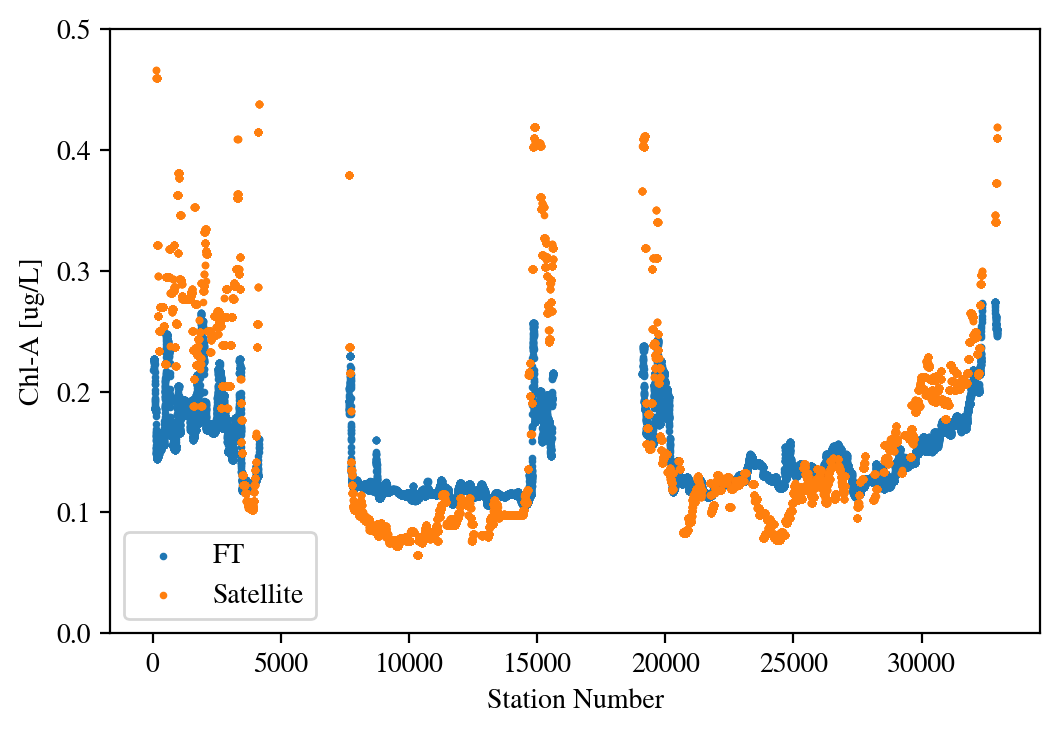

In [12]:
plt.scatter(compiled_results[compiled_results["Src"]=="FT"]["Station"],
            compiled_results[compiled_results["Src"]=="FT"]["Chl-A"], 
            s=3, label="FT")

plt.scatter(compiled_results[compiled_results["Src"]=="FT"]["Station"],
            compiled_results[compiled_results["Src"]=="FT"]["New Sat Chl-A"], 
            s=3, label="Satellite")

plt.xlabel("Station Number")
plt.ylabel("Chl-A [ug/L]")
plt.ylim([0,0.5])
plt.legend()

In [310]:
x = ma.array(ft_pts["New Sat Chl-A"])
y = ma.array(ft_pts["Chl-A"])


# x = x.compressed()
# y = y.compressed()
# x.sum()
# # print(x[5000])
X = ma.array(list(zip(x,y)))

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [283]:
# plt.plot(X, '.')
# plt.plot(y, '.')
type(X)
np.sum(x)
x = x[~np.isnan(x)]
x


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [284]:
x = x[~x.mask]

TypeError: bad operand type for unary ~: 'method'

In [296]:
x.compressed()

array([1.0684789419174194, 1.0684789419174194, 1.0684789419174194, ...,
       0.41941776871681213, 0.41941776871681213, 0.41941776871681213],
      dtype=object)

In [295]:
type(x)

numpy.ma.core.MaskedArray

In [44]:
new_sat_data.iloc[5000:8000]

,0
5093,0.0846935
5094,0.0846935
5095,0.0846935
5096,0.0846935
5097,0.0846935
5098,0.0846935
5099,0.0846935
5100,0.0846935
5101,0.0846935
5102,0.0846935


In [264]:





































x
# np.all(np.isfinite(x))

93        1.06848
94        1.06848
95        1.06848
96        1.06848
97        1.06848
98        1.06848
99        1.06848
100       1.06848
101       1.06848
102       1.06848
103       1.06848
104       1.06848
105       1.06848
106       1.06848
107       1.06848
108       1.06848
109       1.06848
110       1.06848
111       1.06848
112       1.06848
113       1.06848
114       1.06848
115      0.783461
116      0.783461
117      0.783461
118      0.783461
119      0.783461
120      0.548727
121      0.548727
122      0.548727
          ...    
5063    0.0883902
5064    0.0883902
5065    0.0883902
5066    0.0883902
5067    0.0883902
5068    0.0883902
5069    0.0883902
5070    0.0883902
5071    0.0883902
5072    0.0883902
5073    0.0883902
5074    0.0883902
5075    0.0883902
5076    0.0883902
5077    0.0883902
5078    0.0883902
5079    0.0883902
5080    0.0883902
5081    0.0883902
5082    0.0883902
5083    0.0883902
5084    0.0883902
5085    0.0883902
5086    0.0883902
5087    0.

In [265]:
ft_pts = compiled_results[compiled_results["Src"]=="FT"].dropna()
x = ft_pts["New Sat Chl-A"][0:5000]
y = ft_pts["Chl-A"][0:5000]
# x
X = np.array(list(zip(x,y)), dtype='float32')



# # X = ft_pts[["New Sat Chl-A", "Chl-A"]].dropna()

# # X[X.isin([np.nan, np.inf, -np.inf]).any(1)]
# # X.reset_index(inplace=True, drop=True)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)
# X

In [239]:
X.isnull().any()

New Sat Chl-A    False
Chl-A            False
dtype: bool

In [17]:
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

In [266]:
# x = ft_pts["New Sat Chl-A"]
# y = ft_pts["Chl-A"]

# list(x)
# X = ma.array(list(zip(x,y)))


# x = ft_pts["New Sat Chl-A"]
# x = x[~x.mask] # Remove masked points (port stop data)
# y = ft_pts["Chl-A"]
# y = y[~y.mask]


# print(x)
# pd.sort_values(x)
# x = x.sort_values()

# X = pd.DataFrame((x,y))
# X = X.dropna()

# np.isfinite(x)
# print(type(X))



# # Cluster data
# gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
# labels = gmm.fit(X).predict(X)

# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

ft_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(ft_sat_line0.p_value))
print("r-value 0: " + str(ft_sat_line0.r_value))
eq0= "y = " + str(round(ft_sat_line0.slope,2)) + \
      "x + " + str(round(ft_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, ft_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

ft_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(ft_sat_line1.p_value))
print("r-value 1: " + str(ft_sat_line1.r_value))
eq1 = "y = " + str(round(ft_sat_line1.slope,2)) + \
      "x + " + str(round(ft_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, ft_sat_line1.computeY(xp), 'r-', label=eq1)



# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=0.2, cmap='PiYG', zorder=2)

plt.axis("equal")
# plt.xlim([0,0.6])
# plt.ylim([0,0.6])

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("Flow-through Chl-A [ug/L]")

major_ticks = np.arange(0, 0.6, 0.1)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

AttributeError: 'float' object has no attribute 'shape'

In [195]:
X.iloc[1][20373]

0.11388515681632608

In [214]:
x[20373]

masked

In [243]:
compiled_results.iloc[93]

Src                                                             FT
Lat                                                       -36.7378
Long                                                       175.008
Chl-A                                                     0.217991
Timestamp                                                1.582e+09
Station                                                         37
Sat Chl-A                                                   1.5949
Sat Lat                                                   -36.7292
Sat Long                                                   175.021
Sat File         data/satellite-data/autogenerated-csv\V2020041...
New Sat Chl-A                                              1.06848
Name: 93, dtype: object

In [164]:
[new_sat_list[new_sat_list == f] == f]

[93      True
 94      True
 95      True
 96      True
 97      True
 98      True
 99      True
 100     True
 101     True
 102     True
 103     True
 104     True
 105     True
 106     True
 107     True
 108     True
 109     True
 110     True
 111     True
 112     True
 113     True
 114     True
 115     True
 116     True
 117     True
 118     True
 119     True
 120     True
 121     True
 122     True
         ... 
 7889    True
 7890    True
 7891    True
 7892    True
 7893    True
 7894    True
 7895    True
 7896    True
 7897    True
 7898    True
 7899    True
 7900    True
 7901    True
 7902    True
 7903    True
 7904    True
 7905    True
 7906    True
 7907    True
 7908    True
 7909    True
 7910    True
 7911    True
 7912    True
 7913    True
 7914    True
 7915    True
 7916    True
 7917    True
 7918    True
 Name: Timestamp, Length: 7826, dtype: bool]

In [153]:
# compiled_results[compiled_results["Src"] == "FT"]

In [120]:
# compiled_results[compiled_results["Src"] == "FT"]
print(sat_data.lookup_df)
print(sat_data.findBestFile(1584763200.0))

In [ ]:




my_example_nc_file = 'data/satellite-data/V20200412020048.L3m_8D_SNPP_CHL.x_chlor_a.nc'
fh = Dataset(my_example_nc_file, mode='r')

lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
chls = fh.variables['chlor_a'][:]

fh.close()

In [8]:
fh.variables.keys()

odict_keys(['chlor_a', 'lat', 'lon', 'palette'])

In [27]:
lon, lat = np.meshgrid(lons, lats)

chl=np.squeeze(chls)

print(lon.shape)
print(lat.shape)
print(chl.shape)
# df = pd.DataFrame([lon, lat, chl])

(480, 8640)
(480, 8640)
(480, 8640)


In [16]:
df

,0,1,2,3,4,5,6,7,8,9,...,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639
0,-179.979,-179.938,-179.896,-179.854,-179.812,-179.771,-179.729,-179.688,-179.646,-179.604,...,179.604172,179.645844,179.687515,179.729172,179.770844,179.812515,179.854172,179.895844,179.937515,179.979172
1,-30.0208,-30.0625,-30.1042,-30.1458,-30.1875,-30.2292,-30.2708,-30.3125,-30.3542,-30.3958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[0.05987856, 0.059922937, 0.060528573, 0.06586...","[0.060319662, 0.057855785, 0.056257866, 0.0559...","[0.057511065, 0.05571203, 0.05496283, 0.057378...","[0.06274808, 0.059540287, 0.058732588, 0.06194...","[0.07171011, 0.07580612, 0.06978024, 0.0661913...","[0.06983888, 0.06841403, 0.06936561, 0.0703758...","[0.07597647, 0.06938917, 0.06562619, 0.0648491...","[0.07352852, 0.067037374, 0.06266423, 0.061499...","[0.064043775, 0.06602199, 0.066545814, 0.06487...","[0.071973175, 0.081027456, 0.08886131, 0.09520...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Get some parameters for the Stereographic Projection
lon_0 = lons.mean()
lat_0 = lats.mean()

m = Basemap(width=5000000,height=3500000,
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

# Because our lon and lat variables are 1D,
# use meshgrid to create 2D arrays
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(tmax))

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(tmax_units)

# Add Title
plt.title('DJF Maximum Temperature')

plt.show()

ImportError: No module named 'mpl_toolkits.basemap'

In [ ]:
### Utilities
# is_NaN = ft_pts["New Sat Chl-A"].isnull()
# ft_pts[is_NaN]


In [311]:
x = ft_pts["New Sat Chl-A"]
y = ft_pts["Chl-A"]

In [324]:
x

93        1.06848
94        1.06848
95        1.06848
96        1.06848
97        1.06848
98        1.06848
99        1.06848
100       1.06848
101       1.06848
102       1.06848
103       1.06848
104       1.06848
105       1.06848
106       1.06848
107       1.06848
108       1.06848
109       1.06848
110       1.06848
111       1.06848
112       1.06848
113       1.06848
114       1.06848
115      0.783461
116      0.783461
117      0.783461
118      0.783461
119      0.783461
120      0.548727
121      0.548727
122      0.548727
           ...   
25383    0.372834
25384    0.372834
25385    0.372834
25386    0.372834
25387    0.409988
25388    0.409988
25389    0.409988
25390    0.409988
25391    0.409988
25392    0.409988
25393    0.409988
25394    0.409988
25395    0.409988
25396    0.409988
25397    0.409988
25398    0.409988
25399    0.409988
25400    0.409988
25401    0.409988
25402    0.409988
25403    0.409988
25404    0.409988
25405    0.409988
25406    0.409988
25407    0

In [323]:
 == ma.masked

masked

In [13]:
x

NameError: name 'x' is not defined

In [56]:
x = new_sat_data[0]#compiled_results[compiled_results["Src"]=="FT"]["Sat Chl-A"]
y = compiled_results[compiled_results["Src"]=="FT"]["Chl-A"]

# x.tolist(), y.tolist()

x = x.tolist()
y = y.tolist()

X = np.array(list(zip(x,y)))


# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)


# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

ft_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(ft_sat_line0.p_value))
print("r-value 0: " + str(ft_sat_line0.r_value))
eq0= "y = " + str(round(ft_sat_line0.slope,2)) + \
      "x + " + str(round(ft_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, ft_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

ft_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(ft_sat_line1.p_value))
print("r-value 1: " + str(ft_sat_line1.r_value))
eq1 = "y = " + str(round(ft_sat_line1.slope,2)) + \
      "x + " + str(round(ft_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, ft_sat_line1.computeY(xp), 'r-', label=eq1)



# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=0.2, cmap='PiYG', zorder=2)

plt.axis("equal")
plt.xlim([0,0.6])
plt.ylim([0,0.6])

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("Flow-through Chl-A [ug/L]")

major_ticks = np.arange(0, 0.6, 0.1)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

/home/amy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [26]:
len(y)

25320

In [27]:
X

array([[0.        , 0.21799125]])

In [64]:
x = new_sat_data["New Sat Chl-A"]#compiled_results[compiled_results["Src"]=="FT"]["Sat Chl-A"]
y = compiled_results[compiled_results["Src"]=="FT"]["Chl-A"]
X = np.array(list(zip(x,y)))

In [62]:
X

array([[0.21799125, 0.21799125],
       [0.21839398, 0.21839398],
       [0.21839398, 0.21839398],
       ...,
       [0.24698792, 0.24698792],
       [0.24618245, 0.24618245],
       [0.24598109, 0.24598109]])

In [46]:
type(y)

pandas.core.series.Series

In [60]:
# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(X).predict(X)


In [22]:
# new_sat_data["0"]
y[20000]

0.1442913848818797

3608.661033907211


/home/amy/.local/lib/python3.5/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


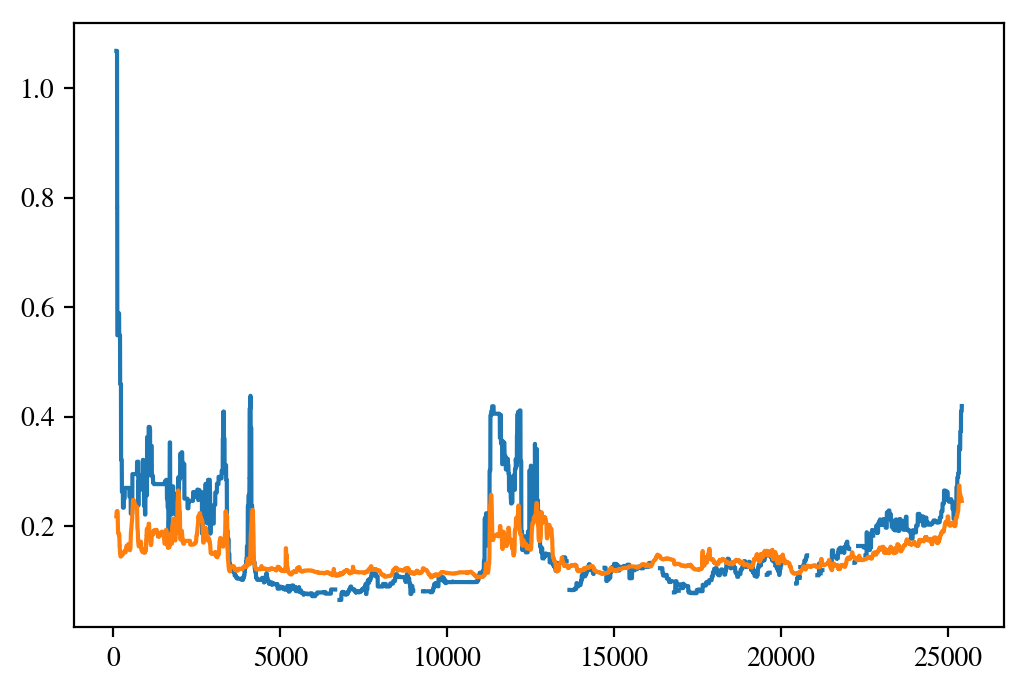

In [99]:
x = new_sat_data[0]#compiled_results[compiled_results["Src"]=="FT"]["Sat Chl-A"]
y = compiled_results[compiled_results["Src"]=="FT"]["Chl-A"]

x_ma = np.ma.array(x)
print(sum(y))
plt.plot(x)
plt.plot(y)
y_ma = np.ma.array(y)
x_clean = x_ma[x_ma.mask == False]
y_clean = y_ma[y_ma.mask == False]

In [93]:
y_clean

masked_array(data=[[0.21799125, 0.21839398, 0.21839398, ..., 0.24698792,
                    0.24618245, 0.24598109]],
             mask=False,
       fill_value=1e+20)

In [24]:
x = new_sat_data[0]#compiled_results[compiled_results["Src"]=="FT"]["Sat Chl-A"]
y = compiled_results[compiled_results["Src"]=="FT"]["Chl-A"]

x_ma = np.ma.array(x)
y_ma = np.ma.array(y)
x_clean = x_ma[x_ma.mask == False]
y_clean = y_ma[y_ma.mask == False]


X = np.array(list(zip(x,y)))
# X = (x,y)

# print(X)

# Cluster data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
labels = gmm.fit(x.T,y.T).predict(x.T,y.T)


# Compute and plot best fit lines for cluster 0
x0 = x[labels == 0]
y0 = y[labels == 0]

ft_sat_line0 = BestFitLine(x0, y0)
print("p-value 0: " + str(ft_sat_line0.p_value))
print("r-value 0: " + str(ft_sat_line0.r_value))
eq0= "y = " + str(round(ft_sat_line0.slope,2)) + \
      "x + " + str(round(ft_sat_line0.intercept,2))

xp = np.linspace(x0.min(), x0.max(), 100)
plt.plot(xp, ft_sat_line0.computeY(xp), 'b-', label=eq0)

# Compute and plot best fit lines for cluster 1
x1 = x[labels == 1]
y1 = y[labels == 1]

ft_sat_line1 = BestFitLine(x1, y1)
print("p-value 1: " + str(ft_sat_line1.p_value))
print("r-value 1: " + str(ft_sat_line1.r_value))
eq1 = "y = " + str(round(ft_sat_line1.slope,2)) + \
      "x + " + str(round(ft_sat_line1.intercept,2))

xp = np.linspace(x1.min(), x1.max(), 100)
plt.plot(xp, ft_sat_line1.computeY(xp), 'r-', label=eq1)



# Plot Clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, s=0.2, cmap='PiYG', zorder=2)

plt.axis("equal")
plt.xlim([0,0.6])
plt.ylim([0,0.6])

plt.xlabel("Satellite Chl-A [ug/L]")
plt.ylabel("Flow-through Chl-A [ug/L]")

major_ticks = np.arange(0, 0.6, 0.1)
plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')

/home/amy/.local/lib/python3.5/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


ValueError: Expected 2D array, got 1D array instead:
array=[1.06847894 1.06847894 1.06847894 ... 0.41941777 0.41941777 0.41941777].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [69]:
(x,y)

(93       0.217991
 94       0.218394
 95       0.218394
 96       0.220408
 97       0.221012
 98       0.223831
 99       0.224636
 100      0.225442
 101      0.225442
 102      0.225442
 103      0.225442
 104      0.225643
 105      0.225845
 106      0.226650
 107      0.226650
 108      0.227053
 109      0.227053
 110      0.227053
 111      0.227053
 112      0.227053
 113      0.227053
 114      0.226650
 115      0.226650
 116      0.226650
 117      0.227053
 118      0.227254
 119      0.227254
 120      0.227254
 121      0.227254
 122      0.227254
            ...   
 25383    0.251619
 25384    0.251619
 25385    0.251619
 25386    0.251619
 25387    0.251619
 25388    0.251619
 25389    0.251821
 25390    0.251821
 25391    0.251821
 25392    0.251821
 25393    0.251619
 25394    0.251619
 25395    0.251619
 25396    0.251619
 25397    0.251015
 25398    0.251015
 25399    0.251015
 25400    0.250814
 25401    0.250814
 25402    0.250210
 25403    0.249203
 25404    0.

[93        1.06848
 94        1.06848
 95        1.06848
 96        1.06848
 97        1.06848
 98        1.06848
 99        1.06848
 100       1.06848
 101       1.06848
 102       1.06848
 103       1.06848
 104       1.06848
 105       1.06848
 106       1.06848
 107       1.06848
 108       1.06848
 109       1.06848
 110       1.06848
 111       1.06848
 112       1.06848
 113       1.06848
 114       1.06848
 115      0.783461
 116      0.783461
 117      0.783461
 118      0.783461
 119      0.783461
 120      0.548727
 121      0.548727
 122      0.548727
            ...   
 25383    0.372834
 25384    0.372834
 25385    0.372834
 25386    0.372834
 25387    0.409988
 25388    0.409988
 25389    0.409988
 25390    0.409988
 25391    0.409988
 25392    0.409988
 25393    0.409988
 25394    0.409988
 25395    0.409988
 25396    0.409988
 25397    0.409988
 25398    0.409988
 25399    0.409988
 25400    0.409988
 25401    0.409988
 25402    0.409988
 25403    0.409988
 25404    0.

In [50]:
np.ma.array(x).filled(fill_value=0).sum()

masked

In [54]:
x.tolist()

[1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 1.0684789419174194,
 0.7834609150886536,
 0.7834609150886536,
 0.7834609150886536,
 0.7834609150886536,
 0.7834609150886536,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778945923,
 0.5487266778

In [57]:
sum(x)

masked

In [61]:
x[5000:]

[0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.08469345420598984,
 0.0846934

In [62]:
x.sort()

In [67]:
len(x)

25320

In [68]:
len(y)

25320

In [69]:
X

array([[1.06847894, 0.21799125],
       [1.06847894, 0.21839398],
       [1.06847894, 0.21839398],
       ...,
       [0.41941777, 0.24698792],
       [0.41941777, 0.24618245],
       [0.41941777, 0.24598109]])

In [70]:
sum(x)

masked

In [71]:
min(x)

0.06502560526132584

In [72]:
max(x)

1.0684789419174194

In [78]:
x_ma = np.ma.array(x)
y_ma = np.ma.array(y)
test = test[test.mask == False]

/home/amy/.local/lib/python3.5/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


In [90]:
test

masked_array(data=[0.07198445498943329, 0.07198445498943329,
                   0.07198445498943329, ..., 0.41941776871681213,
                   0.41941776871681213, 0.41941776871681213],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [89]:
test.mask

array([False, False, False, ..., False, False, False])